# The Biggest Assumption in Portfolio Allocation!

<b> YouTube Tutorial </b> (Published: Sep 29, 2023): https://youtu.be/fY1rtV6qgoo

This tutorial has a [Medium post](https://medium.com/@pythonforquants/you-need-to-stop-using-the-sharpe-ratio-7dfed7183e48).

The question that always gets asked by beginners in finance - is it safe to assume that stock returns are normally distributed?

In short, the answer is nearly always NO. The distribution of asset prices is a result of the complicated micromarket dynamics of trade flow and the distributions of trade price and volumes. But a important distinction is that this assumption of normality CAN give relatively good results for some questions, and disasterous results for others!!!

### The big issues:
- asset returns have skew, and fat-tails
- returns can have serial correlation (successive returns are not independent)
- volatility varies over time (Heteroscedasticity), with sharpe volatility clustering
- there can also be relationships between volatility and asset returns (like Leverage Effect)

We won't discuss correlation structure between assets, but this is one of the biggest dangers of assuming Normality in portfolio modelling. "One of the lessons from past financial crises is that correlations increase in stressed market conditions" [1], however there is more research and development of better ways of incorporating Non-Stationary Asset Correlations into credit and portfolio modelling.

We will learn to understand why it's ok to assume normal distribution for asset returns for questions like:  what is the likely investment returns over a 25 year period?
Compared to when it's not ok to model using the normal distribution, like: what is the probability/risk my investment manager loses all my money this next year?

<i>References:</i>

[1] [Hull, John C. 2009. The credit crunch of 2007: What went wrong? Why? What lessons can be learned? J. Credit Risk 5(2): 3–18.](https://www.researchgate.net/publication/228951360_The_credit_crunch_of_2007_What_went_wrong_Why_What_lessons_can_be_learned)

[2] [Credit Risk Meets Random Matrices: Coping with Non-Stationary Asset Correlations](https://arxiv.org/abs/1803.00261)

In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

sns.set_theme()
colors=sns.color_palette()
colors+=colors
warnings.filterwarnings( "ignore", module = "seaborn\..*" )

In [ ]:
no_portfolio_mgrs = 12

no_returns = np.random.normal(loc=20, scale=8, size=no_portfolio_mgrs)
means = np.random.normal(loc=0.10, scale=0.05, size=no_portfolio_mgrs)
stds = np.random.normal(loc=0.3, scale=0.05, size=no_portfolio_mgrs)
skews = np.random.randn(no_portfolio_mgrs)*0.5

portfolios = [stats.pearson3(loc=mean, scale=std, skew=sk)
              for mean, std, sk in zip(means, stds, skews)]

Text(0.5, 0.98, 'Comparison of Portfolio Managers Returns')

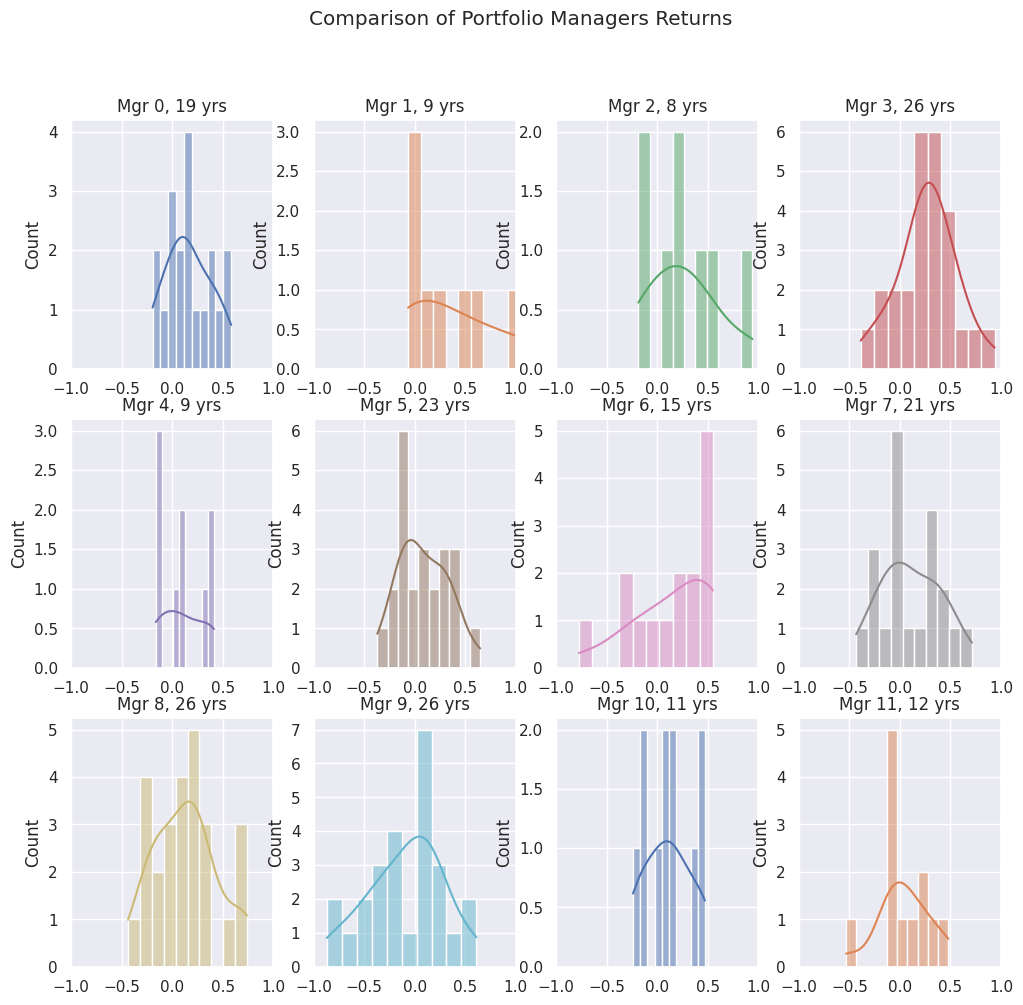

In [ ]:
porfolio_mgr = np.arange(no_portfolio_mgrs)
shape_dim = [3,4]
porfolio_mgr = porfolio_mgr.reshape(shape_dim)
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12,11))

portfolio_returns = {}
for (x,y), portfolio in np.ndenumerate(porfolio_mgr):
    years = int(no_returns[portfolio])
    portfolio_returns[portfolio] = portfolios[portfolio].rvs(size=int(years))

    sns_dist = sns.histplot(portfolio_returns[portfolio],
                            bins=10, kde=True, ax=axs[x,y],
                            color=colors[porfolio_mgr[x][y]])
    axs[x,y].set_title(f"Mgr {porfolio_mgr[x][y]}, {years} yrs")
    axs[x,y].set_xlim(-1,1)

fig.suptitle('Comparison of Portfolio Managers Returns')

## The Central Limit Theorem and it's use in Inferring Sharpe Ratio's

AIM: We would like to compare the Sharpe Ratio between a number of different investment managers portfolio.

How do we estimate the sharpe ratio...

$\Large S_a = \frac{{E}\left[R_a -R_f\right]}{\sigma_a}$

Therefore we could do the simple thing, and take the mean and standard deviation of the returns and compute the sharpe ratio

In [ ]:
risk_free_rate = 0.04
data = {mgr: [np.mean(portfolio),
              np.std(portfolio),
              (np.mean(portfolio)-risk_free_rate)/np.std(portfolio)]
        for mgr, portfolio in portfolio_returns.items()}

df = pd.DataFrame.from_dict(data,
                            orient='index',
                            columns=['mean', 'std', 'sharpe_ratio'])
df.sort_values(by='sharpe_ratio')

,mean,std,sharpe_ratio
9,-0.091563,0.366421,-0.359048
11,0.038395,0.252476,-0.006356
5,0.087498,0.243377,0.195161
7,0.109609,0.291623,0.238696
6,0.145187,0.389395,0.270129
10,0.107600,0.226995,0.297803
8,0.139159,0.310827,0.319016
4,0.109460,0.209471,0.331597
0,0.162294,0.221299,0.552618
2,0.263986,0.343035,0.652954


## The Problem

Unfortunately this is only one value and currently I have no idea what is my uncertainity. Let's dig in to understand more about what we are assuming when we take return means and standard deviations to compute a point estimate sharpe ratio.


We are making a few assumptions to get this point estimate of Sharpe Ratio!

**Most importantly we are estimating parameters using Maximium Likelihood Estimation from the Normal Distribution.

Using Central Limit Theorem $n \rightarrow \infty$

## So what is the Central Limit Theorem?

If you take the sum of any random variables that are independent and identically distributed (i.i.d.) with finite variance, regardless of the distribution, as the number of random variables you are summing approaches infinity, the scaled summation (normalised for mean drift and variance increase) converges in distribution to a normal distribution.

My favourite video on the [Central Limit Theorem](https://youtu.be/zeJD6dqJ5lo?si=g-G7aHhQn8PfqARX) is from the 3Blue1Brown YouTube channel. I recommend giving it a watch.

#### <i>Mathematically<i>:

Suppose $\large X_1, X_2, ... $ is a sequence of i.i.d. random variables with $\large E[X_i] = \mu$ and $\large Var[X_i] = \sigma^2 < \infty\$

Let $\Large S_n := \frac{X_1 + X_2 + ... + X_n}{n}  = \frac{\sum^n X_i}{n}$

Then as $\large n$ approaches $\large \infty$, the random variables $\large \sqrt{n}(S_n - \mu)$ converges in distribution to a normal distribution $\large N(0, \sigma)$

$\Large \sqrt{n} \left(\frac{1}{n}\sum^n_{i=1} X_i - \mu \right) \rightarrow N(0, \sigma^2)$

## An Example to Explain the Problem

Let's say there is an Investment Manager who's portfolio returns look like the distribution below.

$X \sim r_P$

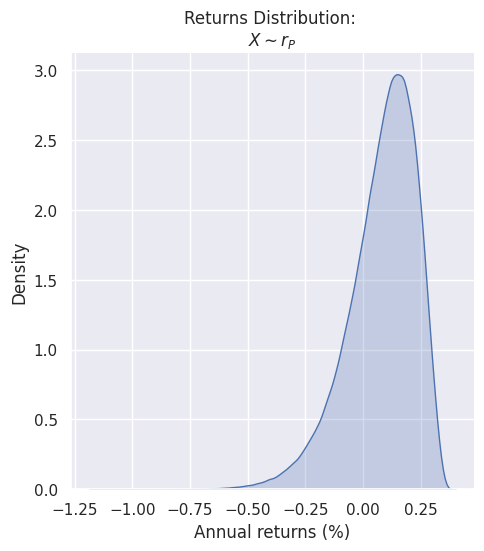

In [ ]:
true_mean = 0.08
true_std = 0.15
true_skew=-1

dist_skew = stats.pearson3.rvs(loc=true_mean, scale=true_std, skew=true_skew,  size=int(1e6))
sns_dist = sns.displot(dist_skew, kind='kde', fill=True)
plt.title('Returns Distribution: \n$X \sim r_P$ ')
plt.xlabel('Annual returns (%)')
plt.show()

## Regular Monte Carlo Experiment

I am 25 years old, and I would like to invest my money for a 25 year period, and look at the likely average returns I would have achieved over the investment holding period.

We want to investigate portfolio characteristics: $\Large Y = g(X)$, where g is a real-valued function.

Specifically, we would like to say something about the expectation: $\large \mu = E\{g(X)\}$

Let's look at the sampling distribution of the mean, by performing a Monte Carlo simulation.

$\Large \hat{\mu}_n = \frac{1}{n}\sum^n_{i=1}g(X_i)$

We are interested in $Y_i$ which are i.i.d. with mean $\mu$ and variance $\sigma^2 = var\{g(X)\}$

$\large \hat{\mu}_n$ becomes the sample mean for $Y$ and the Central Limit Theorem (CLT) says that:

$\Large \hat{\mu}_n \approx N(\mu, \frac{\sigma^2}{n})$

Therefore the empiricial variance can be estimated by:

$\large \hat{\sigma}^2_n = \frac{1}{n}\sum^n_{i=1}\left(g(X_i) - \hat{\mu}_n \right)^2$

The more common metric for Monte Carlo variance is the Standard Error, which is the error due to the fact we are taking an average of <b>randomly generated samples</b>, and so therefore the calculation is itself random. A measure of this error is the standard deviation:

$\large SE(\hat{\mu}) = \frac{\sigma(Y_n)}{\sqrt{n}}$

Where $\large X_i$ is the return in year $\large i$

And $\large X_1, X2, ...$ are independent and identically distributed (i.i.d.). All simulated from the $\large r_P$ distribution

In [ ]:
#define holding period
years = 25
#number of theoretical simulations
M = 10000
#sample from distribution of returns
r_sample = stats.pearson3.rvs(loc=true_mean,
                              scale=true_std,
                              skew=true_skew,
                              size=(years,M))
#check for cases where returns were less than -1 (lost all your money in 1 year!)
bankrupt = (r_sample < -1)
print("Number of times the portfolio ",
      "manager lost your money",
      f"in a single 1 year: {len(r_sample[bankrupt])}")
print(f"Max return in single year {np.max(r_sample)*100:2.1f}%")
print(f"Min return in single year {np.min(r_sample)*100:2.1f}%")

Number of times the portfolio  manager lost your money in a single 1 year: 5
Max return in single year 37.3%
Min return in single year -115.9%


# Take cumulate summation over all paths
Use log returns because we can sum log returns to get actual return over 25 year period

Plot final histogram of returns at and age of 50 years old.

<ipython-input-7-667262e73fb6>:2: RuntimeWarning: invalid value encountered in log
  log_returns = np.log(1 + r_sample)


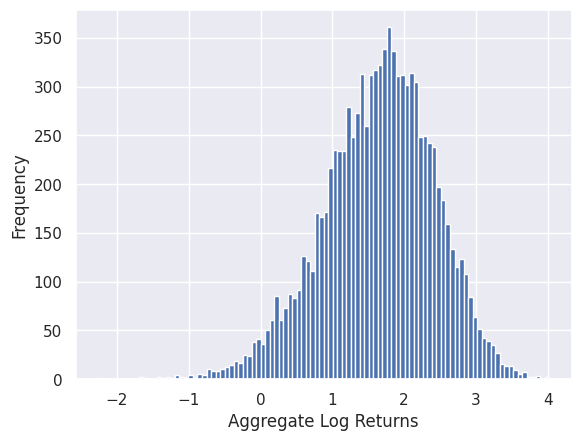

The monte carlo mean estimate is: 1.64
The monte carlo standard error is: 0.02


In [ ]:
#calculate log returns
log_returns = np.log(1 + r_sample)
X = np.cumsum(log_returns, axis=0)
X_T = X[-1,:]
plt.hist(X_T, bins=100)
plt.ylabel('Frequency')
plt.xlabel('Aggregate Log Returns')
plt.show()
print(f"The monte carlo mean estimate is: {np.nanmean(X_T):.2f}")
print(f"The monte carlo standard error is: {1.96*np.nanstd(X_T)/np.sqrt(M):.2f}")

### Changing Timeframes

What happens if the holding period changes, and we consider total returns over different holding periods: 1, 2, 5, 10, 25, 10000 years if all these simulations came from a portfolio manager with the returns profile as described in $r_P$

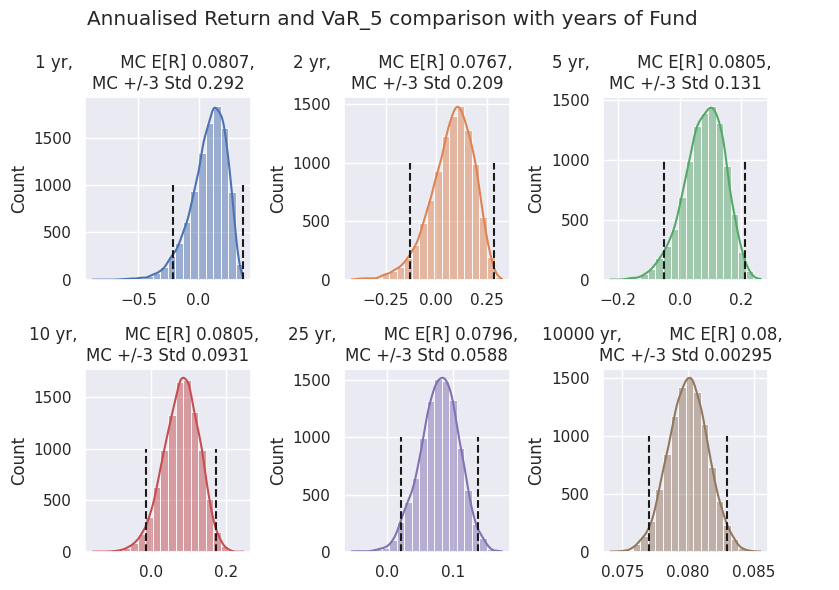

In [ ]:
samples = np.array([1,2,5,10,25,10000]).reshape([2,3])
M = int(1e4)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,6))
count = 0
for (x,y), sample_size in np.ndenumerate(samples):
    means = []
    for _ in range(M):
        dist_skew_sample = stats.pearson3.rvs(loc=true_mean,
                                              scale=true_std,
                                              skew=true_skew,
                                              size=sample_size)
        means.append(np.mean(dist_skew_sample))

    sns.histplot(means, bins=20, kde=True, ax=axs[x,y], color=colors[count])
    mu_est = np.nanmean(means)
    std_est = 1.96*np.nanstd(means)
    axs[x,y].set_title(
        f"{sample_size} yr, \
        MC E[R] {mu_est:.3}, \
        \nMC +/-3 Std {std_est:.3}")
    axs[x,y].plot([mu_est-std_est,mu_est-std_est],[0,1000], 'k--')
    axs[x,y].plot([mu_est+std_est,mu_est+std_est],[0,1000], 'k--')
    count+=1

plt.suptitle("Annualised Return and VaR_5 comparison with years of Fund")
fig.tight_layout()
plt.show()

## Changing number of "Simulations"

In the real world we can not relive 10,000 lives over the 25 year time frame to get the average return. Unfortunately/fortunately we will end up in only 1 of the histogram bars at a particular time point.

Therefore given the data we have right now on the fund, what inference can we make about the returns. One option could be to apply Maximium Likelihood Estimator and trust in the CLT.

### Maximum Likelhood Estimator

The goal of maximum likelihood estimation is to determine the parameters for which the observed data have the highest joint probability.

We write the parameters governing the joint distribution as a vector: $\Large \theta = [\theta_1, \theta_2, ... \theta_n]^T$ and the parameter vector lives in a parameter space $(\Omega)$ and this distribution falls within a parametric family set: $\Large \{f(.|\theta) | \theta \in \Omega\}$. With data $\Large X = (x_1, x_2, ... x_n)$ this gives:

$\Large L_n(\theta) = L_n(\theta|X) = f_n(X|\theta)$

We need to have the <b>probability density function</b> ($f_n$ above) defined.

$\Large f(x) = \frac{1}{\sqrt{2\pi \sigma^2}} exp(-\frac{1}{2}\frac{(x_i - \mu)^2}{\sigma^2})$

<b>The likelihood function:</b> is the joint probability of the observed data as a function of the parameters of the statistical model
If X generates $x_1, x_2, ... x_n$ as an i.i.d. process then the likelihood function can be written as the product of the conditional

$\Large L(\mu, \sigma^2 | x_1, x_2, ... x_n) = \prod^n_{i=1} f(x_i | \mu, \sigma^2)$

$\Large L(\mu, \sigma^2 | x_1, x_2, ... x_n) = \prod^n_{i=1} \frac{1}{\sqrt{2\pi \sigma^2}} exp(-\frac{1}{2}\frac{(x_i - \mu)^2}{\sigma^2})$

$\Large L(\mu, \sigma^2 | x_1, x_2, ... x_n) = (2\pi \sigma^2)^{-\frac{n}{2}} exp\left(-\frac{1}{2 \sigma^2} \sum^n_{i=1}(x_i - \mu)^2\right)$

Although this can yield the right result, this is often computationally difficult to compute (arithmetic underflow problem). Therefore to make this calculation tractable, we can take the log of the function above (this will yeild the summation of larger values), and is an equivalent maximisation statement.



Nice reference for those who who like to understand how to derive the [MLE from the optimisation problem](https://www.statlect.com/fundamentals-of-statistics/maximum-likelihood) of the log-likelihood function of the [normal distribution](https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood) [1] . Below is the maximum likelihood estimate of the variance for normally distributed variables, this is a biased estimate as it underestimate of the actual variance of the larger population, and can be 'corrected' for by subtracting the degrees of freedom from the denominator.

$\Large \hat{\mu}_n = \frac{1}{n}\sum^n_{i=1}r_i$

$\Large \hat{\sigma}^2_n = \frac{1}{n}\sum^n_{i=1}(r_i - \hat{\mu}_n)^2$ (biased estimator)

The important assumption here is that all samples of $r_i$ are assumed to be i.i.d., and come from an underlying normal distribution, which as we've established above is an OK assumption as $n \rightarrow \infty $

<b>References: </b>

[1] Taboga, Marco (2021). "Maximum likelihood estimation", Lectures on probability theory and mathematical statistics. Kindle Direct Publishing. Online appendix. https://www.statlect.com/fundamentals-of-statistics/maximum-likelihood.

mu: 0.08498709530192315 std: 0.18230921353045146


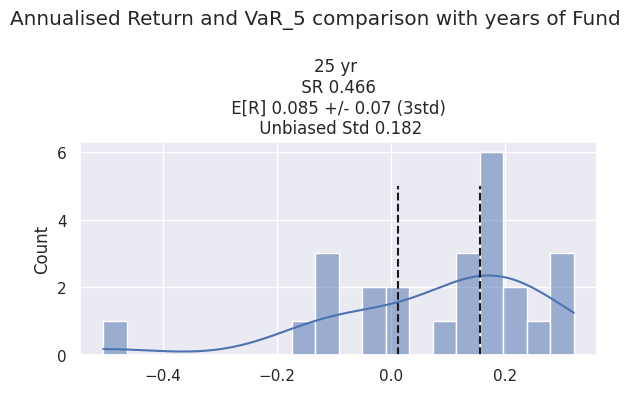

In [ ]:
years = 25

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

dist_skew_sample = stats.pearson3.rvs(loc=true_mean, scale=true_std, skew=true_skew,  size=years)

sns.histplot(dist_skew_sample, bins=20, kde=True, ax=axs)
mu_est = np.nanmean(dist_skew_sample)
std_est = np.nanstd(dist_skew_sample)
se3 = 1.96*np.nanstd(dist_skew_sample)/np.sqrt(years) # mult by 1.96 crit for norm distr 97.5%
axs.set_title(f"{years} yr \n SR {mu_est/std_est:.3} \n E[R] {mu_est:.3} +/- {se3:.2f} (3std) \n Unbiased Std {std_est:.3f}")
axs.plot([mu_est-se3,mu_est-se3],[0,int(years/5)], 'k--')
axs.plot([mu_est+se3,mu_est+se3],[0,int(years/5)], 'k--')
count+=1

print(f"mu: {mu_est} std: {std_est}")
plt.suptitle("Annualised Return and VaR_5 comparison with years of Fund")
fig.tight_layout()
plt.show()

What we have realised. This is only ever a point estimate of the data we have. The less data, the less confident or less certain we can be in our results. This is almost by definition in the way we rely on the CLT.